In [1]:
import jax
import numpy as np
import jax.numpy as jnp
import optax
import scipy.linalg
import scipy.signal
import torch
import matplotlib.pyplot as plt
from flax import linen as nn
from torch.utils.data import Dataset, DataLoader

def np_collate(batch):
    if isinstance(batch[0], np.ndarray):
        return np.stack(batch)
    elif isinstance(batch[0], (tuple,list)):
        transposed = zip(*batch)
        return [np_collate(samples) for samples in transposed]
    else:
        return np.array(batch)

In [2]:
# Setup seed 
torch.random.manual_seed(0)
np.random.seed(0)
key = jax.random.PRNGKey(0)

In [3]:
A = np.array([[0,1],[0,0]])
B = np.array([[0],[1]])
Q = np.array([[1,0],[0,1]])
R = np.array([[0.01]])
R_inv = scipy.linalg.inv(R)

P = scipy.linalg.solve_continuous_are(A,B,Q,R)

Build dynamics simulation

In [4]:
dt = 0.01
state_dim = A.shape[0]
u_dim = B.shape[1]
A_d, B_d, _, _, _ = scipy.signal.cont2discrete((A, B, np.eye(state_dim), np.eye(u_dim)), dt=dt)

def dynamics_step(x, u):
    return A_d @ x + B_d @ u


In [5]:
class PDValueApproximator(nn.Module):
    @nn.compact
    def __call__(self, x):
        y = nn.Dense(128, use_bias=False)(x)
        y = jnp.sin(y)
        y = nn.Dense(128, use_bias=False)(y)
        y = jnp.sin(y)
        y = nn.Dense(64, use_bias=False)(y)
        y = jnp.einsum('...i,...i->...', y, y) + 1e-3 * jnp.einsum('...i,...i->...', x, x)

        return y.squeeze()
    
class SoftPDValueApproximator(nn.Module):
    @nn.compact
    def __call__(self, x):
        y = nn.Dense(128)(x)
        y = jnp.sin(y)
        y = nn.Dense(128)(y)
        y = jnp.sin(y)
        y = nn.Dense(64)(y)
        y = jnp.sin(y)
        y = nn.Dense(1)(y)

        return y.squeeze()

Generate datasets

In [6]:
metric = 1e-4
xs = np.random.uniform(low=-1,high=1, size=(2**16, 2))
norms = np.array([x.T @ x for x in xs])
running_costs = np.where(norms > metric, 1, 0)

class StateDataset(Dataset):
    def __init__(self, xs, running_costs):
        super().__init__()
        self.xs = xs
        self.running_costs = running_costs
    def __len__(self):
        return self.xs.shape[0]
    def __getitem__(self, index):
        return self.xs[index], self.running_costs[index]
    
dataset = StateDataset(xs, running_costs)
dataloader = DataLoader(dataset, batch_size=256, shuffle=True, collate_fn=np_collate, drop_last=False)

Code for evaluate average cumulated costs

In [7]:
def get_mean_and_std_of_policy(model, model_params, model_states, num_of_trajectory = 20, max_T=15):
    
    @jax.jit
    def get_control(x):
        v_gradient, _ = jax.grad(model.apply, argnums=1, has_aux=True)({'params': model_params, **model_states}, x, mutable=list(model_states.keys()))
        u = -jnp.sign(v_gradient @ B) 
        return u
    
    ts = np.arange(0, max_T, dt)
    optimal_cutting_time_list = []

    for i in range(num_of_trajectory):
        x = np.random.uniform(low=-1,high=1, size=(2,))
        for t in ts:
            if x.T @ x <= metric:
                optimal_cutting_time_list.append(t)
                break
            u = np.array(get_control(x))
            x = dynamics_step(x, u)
        if t >= max_T - dt:
            optimal_cutting_time_list.append(max_T)
    
    optimal_cutting_time_list = np.array(optimal_cutting_time_list)

    return np.mean(optimal_cutting_time_list), np.std(optimal_cutting_time_list)

Code for training PD value function

In [8]:
pd_value_function_approximator = PDValueApproximator()
key, key_to_use = jax.random.split(key)
pd_model_variables = pd_value_function_approximator.init(key_to_use, jnp.zeros((1,2)))
pd_model_states, pd_model_params = pd_model_variables.pop('params')
del pd_model_variables
pd_optimizer = optax.adam(learning_rate=1e-3)
pd_optimizer_states = pd_optimizer.init(pd_model_params)

pd_cumulated_cost_during_learning_mean = []
pd_cumulated_cost_during_learning_std = []

def pd_hjb_loss(params, states, xs, running_costs):
    def get_v_gradient(params, states, x):
        return jax.grad(pd_value_function_approximator.apply, argnums=1, has_aux=True)({'params': params, **states}, x, mutable=list(states.keys()))
    def loss(x, running_cost):
        v_gradient, updated_states = get_v_gradient(params, states, x)
        u = -jnp.sign(v_gradient @ B) 
        x_dot = A @ x + B @ u
        v_dot = v_gradient.T @ x_dot
        loss = jnp.abs(v_dot + running_cost)
        return loss, updated_states    
    batch_losses, updated_states = jax.vmap(loss)(xs, running_costs)
    return jnp.mean(batch_losses), updated_states

@jax.jit
def pd_params_update(params, states, optimizer_state, xs, running_costs):
    (loss, updated_states), hjb_grad = jax.value_and_grad(pd_hjb_loss, has_aux=True)(params, states, xs, running_costs)
    updates, optimizer_state = pd_optimizer.update(hjb_grad, optimizer_state)
    params = optax.apply_updates(params, updates)
    return params, updated_states, optimizer_state, loss

pd_losses = []
for epoch in range(100):
    pd_total_loss = 0

    pd_cumulated_cost_mean, pd_cumulated_cost_std = get_mean_and_std_of_policy(pd_value_function_approximator, pd_model_params, pd_model_states)
    pd_cumulated_cost_during_learning_mean.append(pd_cumulated_cost_mean)
    pd_cumulated_cost_during_learning_std.append(pd_cumulated_cost_std)

    for i, (xs, running_costs) in enumerate(dataloader):
        pd_model_params, pd_model_states, pd_optimizer_states, pd_loss = pd_params_update(pd_model_params, pd_model_states, pd_optimizer_states, xs, running_costs)
        pd_total_loss += pd_loss
    pd_losses.append(pd_total_loss / len(dataloader))
    if (epoch+1) % 10 == 0:
        print(f"epoch:{epoch+1}, loss:{pd_total_loss / len(dataloader)}, time to origin:{pd_cumulated_cost_mean}")

pd_cumulated_cost_during_learning_mean = np.array(pd_cumulated_cost_during_learning_mean)
pd_cumulated_cost_during_learning_std = np.array(pd_cumulated_cost_during_learning_std)


epoch:10, loss:0.07184618711471558, time to origin:4.253000000000001
epoch:20, loss:0.05127125605940819, time to origin:3.8064999999999998
epoch:30, loss:0.050909679383039474, time to origin:3.9065
epoch:40, loss:0.044496916234493256, time to origin:3.097
epoch:50, loss:0.035330913960933685, time to origin:2.8405
epoch:60, loss:0.04974454268813133, time to origin:2.9035
epoch:70, loss:0.02857941947877407, time to origin:2.9915000000000003
epoch:80, loss:0.025896722450852394, time to origin:2.7405
epoch:90, loss:0.025598838925361633, time to origin:2.8035
epoch:100, loss:0.026374680921435356, time to origin:3.254


Code for training value function with soft PD method

In [9]:
regularization = 1e0
soft_pd_value_function_approximator = SoftPDValueApproximator()
key, key_to_use = jax.random.split(key)
soft_pd_model_variables = soft_pd_value_function_approximator.init(key_to_use, jnp.zeros((1,2)))
soft_pd_model_states, soft_pd_model_params = soft_pd_model_variables.pop('params')
del soft_pd_model_variables
soft_pd_optimizer = optax.adam(learning_rate=1e-3)
soft_pd_optimizer_states = soft_pd_optimizer.init(soft_pd_model_params)

soft_pd_cumulated_cost_during_learning_mean = []
soft_pd_cumulated_cost_during_learning_std = []

def soft_pd_hjb_loss(params, states, xs, running_costs):
    def get_v_gradient(params, states, x):
        return jax.value_and_grad(soft_pd_value_function_approximator.apply, argnums=1, has_aux=True)({'params': params, **states}, x, mutable=list(states.keys()))
    def get_v_at_zeros(params, states, x):
        return soft_pd_value_function_approximator.apply({'params': params, **states}, jnp.zeros_like(x))
    def loss(x, running_cost):
        (value, updated_states), v_gradient = get_v_gradient(params, states, x)
        value_at_zeros = get_v_at_zeros(params, states, x)
        u = -jnp.sign(v_gradient @ B) 
        x_dot = A @ x + B @ u
        v_dot = v_gradient.T @ x_dot
        loss = jnp.abs(v_dot + running_cost) + regularization * jnp.maximum(0, value_at_zeros-value)
        return loss, updated_states
    batch_losses, updated_states = jax.vmap(loss)(xs, running_costs)
    return jnp.mean(batch_losses), updated_states

def soft_pd_warmup_hjb_loss(params, states, xs, running_costs):
    def get_v_gradient(params, states, x):
        return jax.value_and_grad(soft_pd_value_function_approximator.apply, argnums=1, has_aux=True)({'params': params, **states}, x, mutable=list(states.keys()))
    def get_v_at_zeros(params, states, x):
        return soft_pd_value_function_approximator.apply({'params': params, **states}, jnp.zeros_like(x))
    def loss(x, running_cost):
        (value, updated_states), v_gradient = get_v_gradient(params, states, x)
        value_at_zeros = get_v_at_zeros(params, states, x)
        u = jnp.clip(-R_inv @ B.T @ P @ x, -1, 1)
        x_dot = A @ x + B @ u
        v_dot = v_gradient.T @ x_dot
        loss = jnp.abs(v_dot + running_cost) + regularization * jnp.maximum(0, value_at_zeros-value)
        return loss, updated_states
    batch_losses, updated_states = jax.vmap(loss)(xs, running_costs)
    return jnp.mean(batch_losses), updated_states

@jax.jit
def soft_pd_params_update(params, states, optimizer_state, xs, running_costs):
    (loss, updated_states), hjb_grad = jax.value_and_grad(soft_pd_hjb_loss, has_aux=True)(params, states, xs, running_costs)
    updates, optimizer_state = soft_pd_optimizer.update(hjb_grad, optimizer_state)
    params = optax.apply_updates(params, updates)
    return params, updated_states, optimizer_state, loss

@jax.jit
def soft_pd_params_warmup_update(params, states, optimizer_state, xs, running_costs):
    (loss, updated_states), hjb_grad = jax.value_and_grad(soft_pd_warmup_hjb_loss, has_aux=True)(params, states, xs, running_costs)
    updates, optimizer_state = soft_pd_optimizer.update(hjb_grad, optimizer_state)
    params = optax.apply_updates(params, updates)
    return params, updated_states, optimizer_state, loss

soft_pd_losses = []
warmup_epochs = 20
epochs = 100
for warmup_epoch in range(warmup_epochs):
    soft_pd_total_loss = 0

    soft_pd_cumulated_cost_mean, soft_pd_cumulated_cost_std = get_mean_and_std_of_policy(soft_pd_value_function_approximator, soft_pd_model_params, soft_pd_model_states)
    soft_pd_cumulated_cost_during_learning_mean.append(soft_pd_cumulated_cost_mean)
    soft_pd_cumulated_cost_during_learning_std.append(soft_pd_cumulated_cost_std)

    for i, (xs, running_costs) in enumerate(dataloader):
        soft_pd_model_params, soft_pd_model_states, soft_pd_optimizer_states, soft_pd_loss = soft_pd_params_warmup_update(soft_pd_model_params, soft_pd_model_states, soft_pd_optimizer_states, xs, running_costs)
        soft_pd_total_loss += soft_pd_loss
    soft_pd_losses.append(soft_pd_total_loss / len(dataloader))
    if (warmup_epoch+1) % 10 == 0:
        print(f"epoch:{warmup_epoch+1}, loss:{soft_pd_total_loss / len(dataloader)}, time to origin:{soft_pd_cumulated_cost_mean}")

for epoch in range(warmup_epochs, epochs, 1):
    soft_pd_total_loss = 0

    soft_pd_cumulated_cost_mean, soft_pd_cumulated_cost_std = get_mean_and_std_of_policy(soft_pd_value_function_approximator, soft_pd_model_params, soft_pd_model_states)
    soft_pd_cumulated_cost_during_learning_mean.append(soft_pd_cumulated_cost_mean)
    soft_pd_cumulated_cost_during_learning_std.append(soft_pd_cumulated_cost_std)

    for i, (xs, running_costs) in enumerate(dataloader):
        soft_pd_model_params, soft_pd_model_states, soft_pd_optimizer_states, soft_pd_loss = soft_pd_params_update(soft_pd_model_params, soft_pd_model_states, soft_pd_optimizer_states, xs, running_costs)
        soft_pd_total_loss += soft_pd_loss
    soft_pd_losses.append(soft_pd_total_loss / len(dataloader))
    if (epoch+1) % 10 == 0:
        print(f"epoch:{epoch+1}, loss:{soft_pd_total_loss / len(dataloader)}, time to origin:{soft_pd_cumulated_cost_mean}")

soft_pd_cumulated_cost_during_learning_mean = np.array(soft_pd_cumulated_cost_during_learning_mean)
soft_pd_cumulated_cost_during_learning_std = np.array(soft_pd_cumulated_cost_during_learning_std)


epoch:10, loss:0.035820987075567245, time to origin:3.4850000000000003
epoch:20, loss:0.028686590492725372, time to origin:2.8495
epoch:30, loss:0.02596471644937992, time to origin:4.6155
epoch:40, loss:0.0215497687458992, time to origin:15.0
epoch:50, loss:0.01901579275727272, time to origin:2.8355
epoch:60, loss:0.017010189592838287, time to origin:3.0524999999999998
epoch:70, loss:0.016564253717660904, time to origin:2.838
epoch:80, loss:0.015939142554998398, time to origin:3.0015
epoch:90, loss:0.01528205443173647, time to origin:2.988
epoch:100, loss:0.013889515772461891, time to origin:2.7520000000000002


In [10]:
regularization = 1e0
key, key_to_use = jax.random.split(key)
soft_pd_model_without_warmup_variables = soft_pd_value_function_approximator.init(key_to_use, jnp.zeros((1,2)))
soft_pd_model_without_warmup_states, soft_pd_model_without_warmup_params = soft_pd_model_without_warmup_variables.pop('params')
del soft_pd_model_without_warmup_variables
soft_pd_optimizer_without_warmup_states = soft_pd_optimizer.init(soft_pd_model_without_warmup_params)

soft_pd_without_warmup_cumulated_cost_during_learning_mean = []
soft_pd_without_warmup_cumulated_cost_during_learning_std = []

soft_pd_without_warmup_losses = []

for epoch in range(epochs):
    soft_pd_without_warmup_total_loss = 0

    soft_pd_without_warmup_cumulated_cost_mean, soft_pd_without_warmup_cumulated_cost_std = get_mean_and_std_of_policy(soft_pd_value_function_approximator, soft_pd_model_without_warmup_params, soft_pd_model_without_warmup_states)
    soft_pd_without_warmup_cumulated_cost_during_learning_mean.append(soft_pd_without_warmup_cumulated_cost_mean)
    soft_pd_without_warmup_cumulated_cost_during_learning_std.append(soft_pd_without_warmup_cumulated_cost_std)

    for i, (xs, running_costs) in enumerate(dataloader):
        soft_pd_model_without_warmup_params, soft_pd_model_without_warmup_states, soft_pd_optimizer_states, soft_pd_without_warmup_loss = soft_pd_params_update(soft_pd_model_without_warmup_params, soft_pd_model_without_warmup_states, soft_pd_optimizer_without_warmup_states, xs, running_costs)
        soft_pd_without_warmup_total_loss += soft_pd_without_warmup_loss
    soft_pd_without_warmup_losses.append(soft_pd_without_warmup_total_loss / len(dataloader))
    if (epoch+1) % 10 == 0:
        print(f"epoch:{epoch+1}, loss:{soft_pd_without_warmup_total_loss / len(dataloader)}, time to origin:{soft_pd_without_warmup_cumulated_cost_mean}")

soft_pd_without_warmup_cumulated_cost_during_learning_mean = np.array(soft_pd_without_warmup_cumulated_cost_during_learning_mean)
soft_pd_without_warmup_cumulated_cost_during_learning_std = np.array(soft_pd_without_warmup_cumulated_cost_during_learning_std)

epoch:10, loss:0.11750423163175583, time to origin:15.0
epoch:20, loss:0.08620325475931168, time to origin:15.0
epoch:30, loss:0.07186645269393921, time to origin:15.0
epoch:40, loss:0.06405330449342728, time to origin:15.0
epoch:50, loss:0.05954665318131447, time to origin:14.396
epoch:60, loss:0.05603773891925812, time to origin:14.358500000000001
epoch:70, loss:0.05335845798254013, time to origin:14.264
epoch:80, loss:0.051237814128398895, time to origin:15.0
epoch:90, loss:0.048983000218868256, time to origin:14.323000000000002
epoch:100, loss:0.04730803892016411, time to origin:14.2865


Make plots

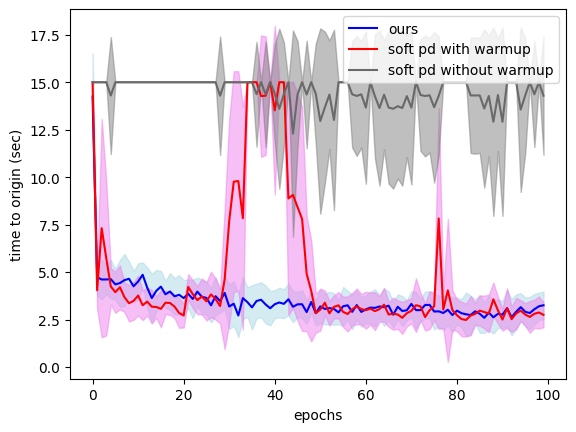

In [11]:
plt.figure()

plt.plot(pd_cumulated_cost_during_learning_mean, color="blue", label="ours")
plt.fill_between(range(len(pd_cumulated_cost_during_learning_mean)), 
                 pd_cumulated_cost_during_learning_mean+pd_cumulated_cost_during_learning_std, 
                 pd_cumulated_cost_during_learning_mean-pd_cumulated_cost_during_learning_std, color="lightblue", alpha=0.5)

plt.plot(soft_pd_cumulated_cost_during_learning_mean, color="red", label="soft pd with warmup")
plt.fill_between(range(len(soft_pd_cumulated_cost_during_learning_mean)),
                soft_pd_cumulated_cost_during_learning_mean + soft_pd_cumulated_cost_during_learning_std, 
                soft_pd_cumulated_cost_during_learning_mean - soft_pd_cumulated_cost_during_learning_std,
                color="violet", alpha=0.5)

plt.plot(soft_pd_without_warmup_cumulated_cost_during_learning_mean, color="dimgray", label="soft pd without warmup")
plt.fill_between(range(len(soft_pd_cumulated_cost_during_learning_mean)),
                soft_pd_without_warmup_cumulated_cost_during_learning_mean + soft_pd_without_warmup_cumulated_cost_during_learning_std, 
                soft_pd_without_warmup_cumulated_cost_during_learning_mean - soft_pd_without_warmup_cumulated_cost_during_learning_std,
                color="gray", alpha=0.5)

plt.legend(loc="upper right")
plt.xlabel("epochs")
plt.ylabel("time to origin (sec)")
plt.show()

Load results from level set methods: Mitchell, Ian M., and Jeremy A. Templeton. "A toolbox of Hamilton-Jacobi solvers for analysis of nondeterministic continuous and hybrid systems." International workshop on hybrid systems: computation and control. Berlin, Heidelberg: Springer Berlin Heidelberg, 2005.

In [12]:
import os
import scipy.io
from scipy.interpolate import RegularGridInterpolator

results_by_level_set_method = scipy.io.loadmat(os.path.normpath(
    os.path.join(
        os.path.dirname(os.path.abspath("")),
        "examples/data/time_optimal_control_for_double_integrator_results_from_level_set_methods.mat",
        )
    ))

value_function_by_level_set_method = results_by_level_set_method["mttr"].T
value_function_by_analytical = results_by_level_set_method["attr"].T

grid_info = results_by_level_set_method["gridOut"]

pos_span = np.linspace(grid_info["min"][0][0][0][0], grid_info["max"][0][0][0][0], grid_info["N"][0][0][0][0])
vel_span = np.linspace(grid_info["min"][0][0][1][0], grid_info["max"][0][0][1][0], grid_info["N"][0][0][1][0])

dv = grid_info["dx"][0][0][1][0]

diffVdiffvel_by_level_set = (value_function_by_level_set_method[2:, :] - value_function_by_level_set_method[:-2, :]) / (2 * dv)

get_pVpvel= RegularGridInterpolator((vel_span[1:-1], pos_span), diffVdiffvel_by_level_set, method="nearest", bounds_error=False ,fill_value=None) 

def get_level_set_control(x):
    pVpvel = get_pVpvel(np.flip(x))
    return -np.array(np.sign(pVpvel))

def get_analytical_control(x):
    if x.T @ x <= metric:
        u = 0.0
    elif (x[1] < 0 and x[0] <= 0.5 * x[1]**2) or (x[1] >= 0 and x[0] < -0.5*x[1]**2):
        u = 1.0
    else:
        u = -1.0
    return np.array([u])

Test policy

In [16]:
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
from matplotlib import animation

def test_learned_policy(x0, T=5):

    @jax.jit
    def get_pd_control(x):
        v_gradient, _ = jax.grad(pd_value_function_approximator.apply, argnums=1, has_aux=True)({'params': pd_model_params, **pd_model_states}, x, mutable=list(pd_model_states.keys()))
        u = -jnp.sign(v_gradient @ B) 
        return u
    
    @jax.jit
    def get_soft_pd_control(x):
        v_gradient, _ = jax.grad(soft_pd_value_function_approximator.apply, argnums=1, has_aux=True)({'params': soft_pd_model_params, **soft_pd_model_states}, x, mutable=list(soft_pd_model_states.keys()))
        u = -jnp.sign(v_gradient @ B) 
        return u
    
    @jax.jit 
    def get_soft_pd_without_warmup_control(x):
        v_gradient, _ = jax.grad(soft_pd_value_function_approximator.apply, argnums=1, has_aux=True)({
            'params': soft_pd_model_without_warmup_params, **soft_pd_model_without_warmup_params}, x, mutable=list(soft_pd_model_states.keys()))
        u = -jnp.sign(v_gradient @ B) 
        return u

    ts = np.arange(0, T, dt)
    xs_pd = [x0]
    xs_soft_pd = [x0]
    xs_soft_pd_without_warmup = [x0]
    xs_lqr = [x0]
    xs_level_set = [x0]
    xs_analytical = [x0]
    us_pd = []
    us_soft_pd = []
    us_soft_pd_without_warmup = []
    us_lqr = []
    us_level_set = []
    us_analytical = []
    optimal_t_lqr = T
    optimal_t_pd = T
    optimal_t_soft_pd = T
    optimal_t_soft_pd_without_warmup = T
    optimal_t_level_set = T
    optimal_t_analytical = T

    for t in ts:
        us_pd.append(np.array(get_pd_control(xs_pd[-1])))
        xs_pd.append(dynamics_step(xs_pd[-1], us_pd[-1]))
        if xs_pd[-1].T @ xs_pd[-1] <= metric:
            optimal_t_pd = min(t, optimal_t_pd)

        us_soft_pd.append(np.array(get_soft_pd_control(xs_soft_pd[-1])))
        xs_soft_pd.append(dynamics_step(xs_soft_pd[-1], us_soft_pd[-1]))
        if xs_soft_pd[-1].T @ xs_soft_pd[-1] <= metric:
            optimal_t_soft_pd = min(t, optimal_t_soft_pd)

        us_soft_pd_without_warmup.append(np.array(get_soft_pd_without_warmup_control(xs_soft_pd_without_warmup[-1])))
        xs_soft_pd_without_warmup.append(dynamics_step(xs_soft_pd_without_warmup[-1], us_soft_pd_without_warmup[-1]))
        if xs_soft_pd_without_warmup[-1].T @ xs_soft_pd_without_warmup[-1] <= metric:
            optimal_t_soft_pd_without_warmup = min(t, optimal_t_soft_pd_without_warmup) 

        us_lqr.append(np.clip(-R_inv @ B.T @ P @ xs_lqr[-1], -1, 1))
        xs_lqr.append(dynamics_step(xs_lqr[-1], us_lqr[-1]))
        if xs_lqr[-1].T @ xs_lqr[-1] <= metric:
            optimal_t_lqr = min(t, optimal_t_lqr)

        us_level_set.append(get_level_set_control(xs_level_set[-1]))
        xs_level_set.append(dynamics_step(xs_level_set[-1], us_level_set[-1]))
        if xs_level_set[-1].T @ xs_level_set[-1] <= metric:
            optimal_t_level_set = min(t, optimal_t_level_set)

        us_analytical.append(get_analytical_control(xs_analytical[-1]))
        xs_analytical.append(dynamics_step(xs_analytical[-1], us_analytical[-1]))
        if xs_analytical[-1].T @ xs_analytical[-1] <= metric:
            optimal_t_analytical = min(t, optimal_t_analytical)
    
    xs_pd = np.array(xs_pd)
    xs_soft_pd = np.array(xs_soft_pd)
    xs_soft_pd_without_warmup = np.array(xs_soft_pd_without_warmup)
    xs_lqr = np.array(xs_lqr)
    xs_level_set = np.array(xs_level_set)
    xs_analytical = np.array(xs_analytical)

    return ts, xs_pd, xs_soft_pd, xs_soft_pd_without_warmup, xs_lqr, xs_level_set, xs_analytical, optimal_t_pd, optimal_t_soft_pd, optimal_t_soft_pd_without_warmup, optimal_t_lqr, optimal_t_level_set, optimal_t_analytical

def visualize_traj(ts, xs_pd, xs_soft_pd, xs_soft_pd_without_warmup, xs_lqr, xs_level_set, xs_analytical, optimal_t_pd, optimal_t_soft_pd, optimal_t_soft_pd_without_warmup, optimal_t_lqr, optimal_t_level_set, optimal_t_analytical):

    fig, ax = plt.subplots()
    ax.plot(ts, xs_pd[:-1, 0], '-.', color = 'blue',)
    ax.plot(ts, xs_pd[:-1, 1], '-', color = 'blue',)
    if xs_pd[-1].T @ xs_pd[-1] <= metric:
        ax.vlines(optimal_t_pd, -0.7, 0.7, colors='blue', linestyles='dashed')
    
    ax.plot(ts, xs_soft_pd[:-1, 0], '-.', color = 'red')
    ax.plot(ts, xs_soft_pd[:-1, 1], '-', color = 'red')
    if xs_soft_pd[-1].T @ xs_soft_pd[-1] <= metric:
        ax.vlines(optimal_t_soft_pd, -0.7, 0.7, colors='red', linestyles='dashed')

    ax.set_ylim(ax.get_ylim())

    ax.plot(ts, xs_soft_pd_without_warmup[:-1, 0], '-.', color = 'grey')
    ax.plot(ts, xs_soft_pd_without_warmup[:-1, 1], '-', color = 'grey')
    if xs_soft_pd_without_warmup[-1].T @ xs_soft_pd_without_warmup[-1] <= metric:
        ax.vlines(optimal_t_soft_pd_without_warmup, -0.7, 0.7, colors='grey', linestyles='dashed')

    ax.plot(ts, xs_lqr[:-1, 0], '-.', color = 'green')
    ax.plot(ts, xs_lqr[:-1, 1], '-', color='green')
    if xs_lqr[-1].T @ xs_lqr[-1] <= metric:
        ax.vlines(optimal_t_lqr, -0.7, 0.7, colors='green', linestyles='dashed')
    
    ax.plot(ts, xs_analytical[:-1, 0], '-.', color = 'orange')
    ax.plot(ts, xs_analytical[:-1, 1], '-', color = 'orange')
    if xs_analytical[-1].T @ xs_analytical[-1] <= metric:
        ax.vlines(optimal_t_analytical, -0.7, 0.7, colors='orange',linestyles='dashed')

    ax.plot(ts, xs_level_set[:-1, 0], '-.', color = 'purple')
    ax.plot(ts, xs_level_set[:-1, 1], '-', color = 'purple')
    if xs_level_set[-1].T @ xs_level_set[-1] <= metric:
        ax.vlines(optimal_t_level_set, -0.7, 0.7, colors='purple', linestyles='dashed')

    methods_legends_handle = [Line2D([0],[0], color='blue', label='ours'),
                            Line2D([0],[0], color='red', label="soft pd with warmup"),
                            Line2D([0],[0], color='grey', label="soft pd without warmup"),
                            Line2D([0],[0], color='green', label="lqr"),
                            Line2D([0],[0], color='orange', label="analytical"),
                            Line2D([0],[0], color='purple', label="level set")
                            ]
    
    states_legends_handle = [Line2D([0],[0], color="blue", linestyle="dashdot", label="pos"),
                            Line2D([0],[0], color="blue", linestyle="solid", label="vel"),
                            Line2D([0],[0], color="blue", linestyle="dashed", label="time to origin")
                            ]

    methods_legends = ax.legend(handles=methods_legends_handle, loc="upper right")
    ax.add_artist(methods_legends)
    ax.legend(handles=states_legends_handle, loc="lower right")
    ax.set_xlabel("time")
    ax.set_ylabel("states")
    ax.set_title("double integrator optimal time control")

def anim_pd_traj(ts, xs_pd):
    fig = plt.figure()
    ax = plt.axes()
    x_range = np.array([-1, 1]) 
    y_range = np.array([-1, 1])
    box_width = 0.2
    box_height = 0.1 
    def draw_frame(i):
        ax.clear()
        ax.axis('equal')
        ax.set_xlim(x_range)
        ax.set_ylim(y_range)
        
        box = Rectangle([xs_pd[i,0]-box_width/2, -box_height/2], box_width, box_height, color="b")
        ax.hlines(y=0, xmin=x_range[0], xmax=x_range[1], colors="k", linestyles="-.")
        ax.vlines(x=0, ymin=y_range[0], ymax=y_range[1], colors="k", linestyles="-.")

        ax.add_patch(box)
        ax.set_title("{:.1f}s".format(ts[i]))

    anim = animation.FuncAnimation(fig, draw_frame, frames=range(0, ts.shape[0], 10), repeat=False)

    return fig, anim

mean pd:  2.6149999999999998
mean soft pd:  2.633
mean soft pd without warmup:  4.611
mean lqr:  4.104000000000001
mean level set 1.6170000000000002
mean analytical set 1.572
std pd:  0.8935574967510485
std soft pd:  0.8906520083624131
std soft pd without warmup list:  1.1669999999999998
std lqr:  1.281602122345309
std level set 0.6021802055863344
std analytical set 0.5365407719828942


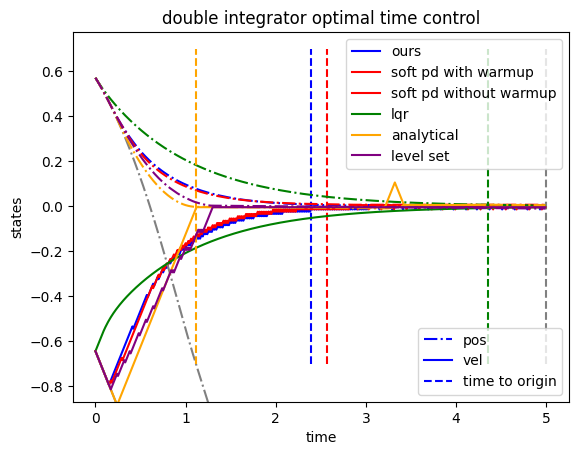

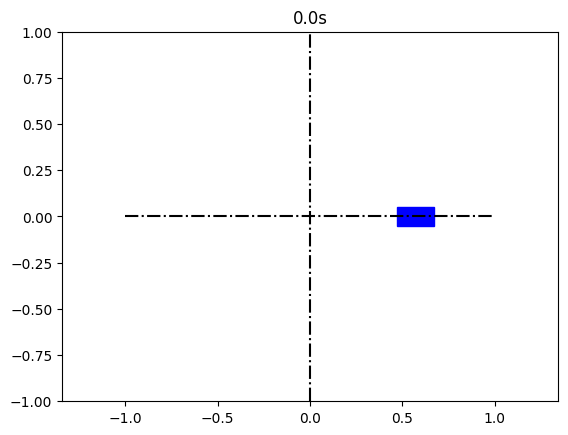

In [17]:
optimal_t_pd_list = []
optimal_t_soft_pd_list = []
optimal_t_soft_pd_without_warmup_list = []
optimal_t_lqr_list = []
optimal_t_level_set_list = []
optimal_t_analytical_list = []

x0 = np.random.uniform(low=-1,high=1, size=(2,))
ts, xs_pd, xs_soft_pd, xs_soft_pd_without_warmup, xs_lqr, xs_level_set, xs_analytical, optimal_t_pd, optimal_t_soft_pd, optimal_t_soft_pd_without_warmup, optimal_t_lqr, optimal_t_level_set, optimal_t_analytical = test_learned_policy(x0)
optimal_t_pd_list.append(optimal_t_pd)
optimal_t_soft_pd_list.append(optimal_t_soft_pd)
optimal_t_soft_pd_without_warmup_list.append(optimal_t_soft_pd_without_warmup)
optimal_t_lqr_list.append(optimal_t_lqr)
optimal_t_level_set_list.append(optimal_t_level_set)
optimal_t_analytical_list.append(optimal_t_analytical)
visualize_traj(ts, xs_pd, xs_soft_pd, xs_soft_pd_without_warmup, xs_lqr, xs_level_set, xs_analytical, optimal_t_pd, optimal_t_soft_pd, optimal_t_soft_pd_without_warmup, optimal_t_lqr, optimal_t_level_set, optimal_t_analytical)
fig, anim = anim_pd_traj(ts, xs_pd)

for i in range(1, 10):
    x0 = np.random.uniform(low=-1,high=1, size=(2,))
    ts, xs_pd, xs_soft_pd, xs_soft_pd_without_warmup, xs_lqr, xs_level_set, xs_analytical, optimal_t_pd, optimal_t_soft_pd, optimal_t_soft_pd_without_warmup, optimal_t_lqr, optimal_t_level_set, optimal_t_analytical = test_learned_policy(x0)
    optimal_t_pd_list.append(optimal_t_pd)
    optimal_t_soft_pd_list.append(optimal_t_pd)
    optimal_t_soft_pd_without_warmup_list.append(optimal_t_soft_pd_without_warmup)
    optimal_t_lqr_list.append(optimal_t_lqr)
    optimal_t_level_set_list.append(optimal_t_level_set)
    optimal_t_analytical_list.append(optimal_t_analytical)

optimal_t_pd_list = np.array(optimal_t_pd_list)
optimal_t_soft_pd_list = np.array(optimal_t_soft_pd_list)
optimal_t_lqr_list = np.array(optimal_t_lqr_list)
optimal_t_level_set_list = np.array(optimal_t_level_set_list)
optimal_t_analytical_list = np.array(optimal_t_analytical_list)
optimal_t_soft_pd_without_warmup_list = np.array(optimal_t_soft_pd_without_warmup_list)

print("mean pd: ", np.mean(optimal_t_pd_list))
print("mean soft pd: ", np.mean(optimal_t_soft_pd_list))
print("mean soft pd without warmup: ", np.mean(optimal_t_soft_pd_without_warmup_list))
print("mean lqr: ", np.mean(optimal_t_lqr_list))
print("mean level set", np.mean(optimal_t_level_set_list))
print("mean analytical set", np.mean(optimal_t_analytical_list))

print("std pd: ", np.std(optimal_t_pd_list))
print("std soft pd: ", np.std(optimal_t_soft_pd_list))
print("std soft pd without warmup list: ", np.std(optimal_t_soft_pd_without_warmup_list))
print("std lqr: ", np.std(optimal_t_lqr_list))
print("std level set", np.std(optimal_t_level_set_list))
print("std analytical set", np.std(optimal_t_analytical_list))

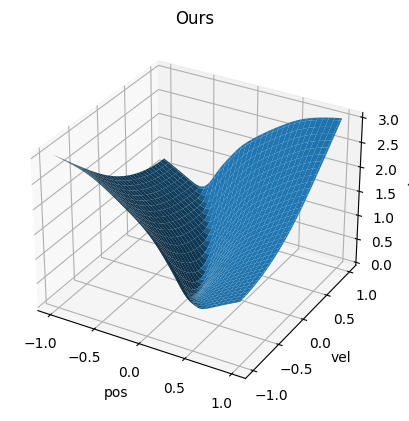

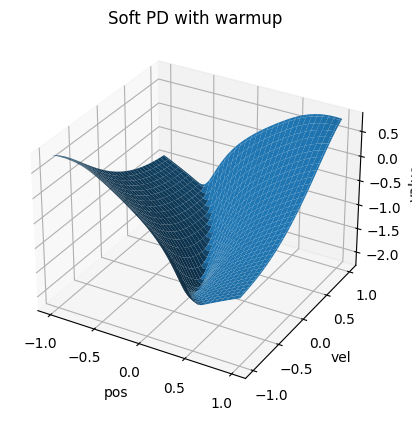

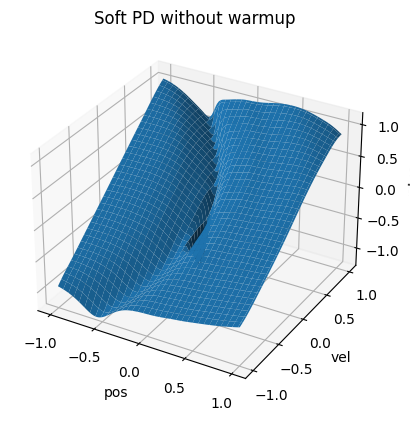

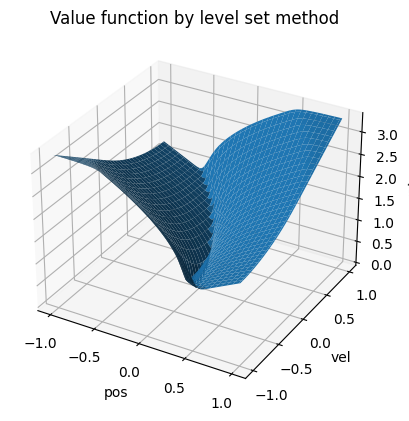

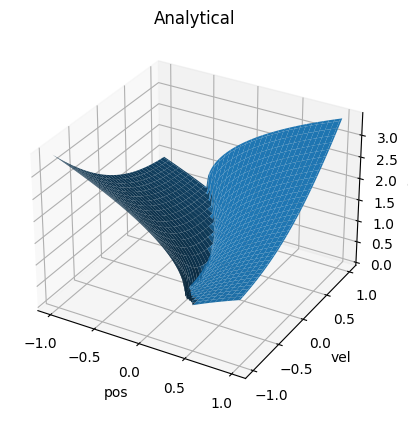

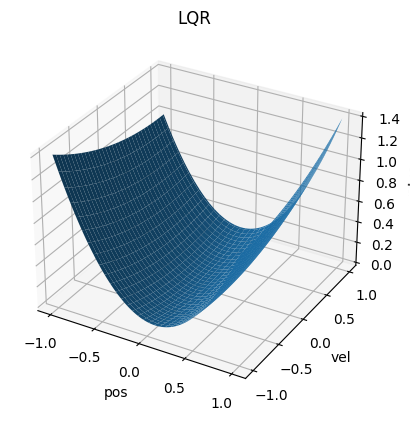

In [ ]:
def visualize_learned_value_landscope(model, model_params, model_states, x_direction, y_direction, 
                        x_range=np.linspace(-1, 1, 101), y_range=np.linspace(-1, 1, 101), title="Learned value function"):
    """
    This function help to draw value function landscope for learn function,
    
    x_direction and y_direction should be perpenticular to each other, suppose a_i \in x_range, b_i \in y_range, then x_i = a_i * x_direction + b_i * y_direction.
    This is prepare for visualize state dimension higher than 2.

    Args:
        model: nn network object
        model_params: params for learned nn networks
        model_states: params for neural network states such as bn statistics
        x_direction: x axis direction
        y_direction: y axis direction
        x_range: the ranges for x direction
        y_range: the range for y direction
    """
    

    quick_apply = jax.jit(model.apply, static_argnames=["train"])
    X, Y = np.meshgrid(x_range, y_range)
    v_learned = np.zeros_like(X)

    for i in range(X.shape[0]):
        for j in range(Y.shape[1]):
            x = X[i,j] * x_direction
            x += Y[i,j] * y_direction
            v_learned[i,j] = quick_apply({"params":model_params, **model_states}, x)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, v_learned)
    ax.set_xlabel(f"pos")
    ax.set_ylabel(f"vel")
    ax.set_zlabel('value')
    plt.title(title)

def visualize_level_set_value_landscope():
    Pos, Vel = np.meshgrid(pos_span, vel_span)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(Pos, Vel, value_function_by_level_set_method)
    ax.set_xlabel(f"pos")
    ax.set_ylabel(f"vel")
    ax.set_zlabel('value')
    plt.title("Value function by level set method")

def visualize_analytical_value_landscope():
    Pos, Vel = np.meshgrid(pos_span, vel_span)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(Pos, Vel, value_function_by_analytical)
    ax.set_xlabel(f"pos")
    ax.set_ylabel(f"vel")
    ax.set_zlabel('value')
    plt.title("Analytical")

def visualize_lqr_value_landscope():
    Pos, Vel = np.meshgrid(pos_span, vel_span)
    v_lqr = np.zeros_like(Pos)
    for i in range(Pos.shape[0]):
        for j in range(Vel.shape[1]):
            x = np.array([Pos[i,j], Vel[i,j]])
            v_lqr[i, j] = x.T @ P @ x
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(Pos, Vel, v_lqr)
    ax.set_xlabel(f"pos")
    ax.set_ylabel(f"vel")
    ax.set_zlabel('value')
    plt.title("LQR")

x_direction = np.array([1,0])
y_direction = np.array([0,1])
visualize_learned_value_landscope(pd_value_function_approximator, pd_model_params, pd_model_states, x_direction=x_direction, y_direction=y_direction, title="Ours")
visualize_learned_value_landscope(soft_pd_value_function_approximator, soft_pd_model_params, soft_pd_model_states, x_direction=x_direction, y_direction=y_direction, title="Soft PD with warmup")
visualize_learned_value_landscope(soft_pd_value_function_approximator, soft_pd_model_without_warmup_params, soft_pd_model_without_warmup_states, x_direction=x_direction, y_direction=y_direction, title="Soft PD without warmup")
visualize_level_set_value_landscope()
visualize_analytical_value_landscope()
visualize_lqr_value_landscope()